In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics.pairwise
import numba
from numba import jit
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_csv("data.txt", sep= "\t")

In [3]:
dat1 = pd.read_csv("dest.txt", sep ='\t')

In [4]:
dat1.shape

(36407, 144)

In [5]:
dat = dat.dropna(axis=0, how='any')
dat1 = dat1.dropna(axis=0, how='any')

In [6]:
user_list = dat.groupby(["user_id"]).count().reset_index().sort(['cnt'], ascending=[0])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [147]:
userlistname = pd.DataFrame(user_list['user_id'][1:1000])

In [148]:
user = pd.merge(userlistname, dat, left_on = "user_id", right_on = 'user_id')

In [149]:
hotel_list = dat.groupby(["hotel_id"]).count().reset_index().sort(['cnt'], ascending=[0])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [150]:
hotellistname = pd.DataFrame(hotel_list['hotel_id'][1:30])

In [151]:
hotel1 = pd.merge(hotellistname, dat, left_on = "hotel_id", right_on = 'hotel_id')

In [152]:
hotelF = pd.merge(hotel1, dat1, left_on = 'srch_destination_id', right_on = 'srch_destination_id')

In [153]:
#User Data

In [154]:
user = user[['user_id','user_location_latitude','user_location_longitude','is_mobile','is_package','channel','srch_adults_cnt','srch_children_cnt']]

In [155]:
user_temp=user.groupby(['user_id'])['user_location_latitude','user_location_longitude','is_mobile','is_package','channel','srch_adults_cnt','srch_children_cnt'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [156]:
dummies = pd.get_dummies(user_temp['channel']).rename(columns=lambda x: 'Ctgc_' + str(x))
user_temp = pd.concat([user_temp, dummies], axis=1)


In [157]:
user_temp.drop(['channel'], inplace=True, axis=1)

In [166]:
weight_vector=[10,10,8,9,8,8] + [1]*9
#weight_vector=[0.01,0.01,0.01,0.01,0.01,0.01] + [10]*11

In [167]:
user_temp.shape

(999, 16)

In [168]:
namelist= list(user_temp["user_id"])

In [169]:
user_temp1 = user_temp.ix[:,1:]

In [170]:
len(weight_vector)

15

In [171]:
user_temp1 = user_temp1*weight_vector

In [172]:
mu = user_temp1.mean()
std = user_temp1.std()

In [173]:
user_temp1_ad = (user_temp1.as_matrix() - mu[:,None].transpose())/(std[:,None].transpose()+1e-6)

In [174]:
result = sklearn.metrics.pairwise.cosine_similarity(user_temp1_ad, Y=None, dense_output=True)

In [175]:
result

array([[ 1.        , -0.42233327, -0.49071905, ...,  0.5396395 ,
        -0.30390842, -0.11682016],
       [-0.42233327,  1.        , -0.11060034, ..., -0.36640496,
        -0.14383415, -0.1872887 ],
       [-0.49071905, -0.11060034,  1.        , ..., -0.55007669,
         0.47236392,  0.21123623],
       ..., 
       [ 0.5396395 , -0.36640496, -0.55007669, ...,  1.        ,
         0.13371792, -0.09016782],
       [-0.30390842, -0.14383415,  0.47236392, ...,  0.13371792,
         1.        , -0.39914863],
       [-0.11682016, -0.1872887 ,  0.21123623, ..., -0.09016782,
        -0.39914863,  1.        ]])

In [176]:
result = (result+1)/2

In [177]:
result

array([[ 1.        ,  0.28883337,  0.25464048, ...,  0.76981975,
         0.34804579,  0.44158992],
       [ 0.28883337,  1.        ,  0.44469983, ...,  0.31679752,
         0.42808292,  0.40635565],
       [ 0.25464048,  0.44469983,  1.        , ...,  0.22496165,
         0.73618196,  0.60561812],
       ..., 
       [ 0.76981975,  0.31679752,  0.22496165, ...,  1.        ,
         0.56685896,  0.45491609],
       [ 0.34804579,  0.42808292,  0.73618196, ...,  0.56685896,
         1.        ,  0.30042568],
       [ 0.44158992,  0.40635565,  0.60561812, ...,  0.45491609,
         0.30042568,  1.        ]])

In [178]:
#Hotel Data

In [179]:
hotel1 = hotelF[hotelF.columns[[0,21,22,24,25]]]

In [180]:
hotel2 = hotelF[hotelF.columns[28:170]]

In [181]:
hotel_att = pd.concat([hotel1, hotel2], axis=1)

In [182]:
df_hist = pd.get_dummies(hotel_att['hist_price_band'])

In [183]:
df_pop = pd.get_dummies(hotel_att['popularity_band'])

In [184]:
hotel_att1 = pd.concat([hotel_att, df_hist,df_pop], axis=1)

In [185]:
hotel_att1 = hotel_att1.drop(hotel_att1.columns[[3, 4]], axis=1)

In [186]:
hotel_att2 = hotel_att1.groupby(['hotel_id']).mean()

In [187]:
M = hotel_att2.as_matrix()
M_u = hotel_att2.mean()
std_u = hotel_att2.std() 
#M_std = hotel_att2.std()
item_mean_subtracted = (M - M_u[:, None].transpose())/std_u[:,None].transpose()


In [188]:
hotel_result = sklearn.metrics.pairwise.cosine_similarity(item_mean_subtracted, Y=None, dense_output=True)

In [189]:
hotel_weight = (hotel_result+1)/2

In [190]:
L = list(hotel_att2.index)

In [191]:
def hotel_search(a,b):
    idx_a = L.index(a)
    idx_b = L.index(b)
    return(hotel_weight[idx_a,idx_b])

In [192]:
def user_search(a,b):
    idx_a = namelist.index(a)
    idx_b = namelist.index(b)
    return(result[idx_a,idx_b])

In [193]:
grouped=hotelF.groupby(['user_id','hotel_id'])
df=grouped[['is_booking','cnt']].agg(['sum'])

In [194]:
grouped_1=hotelF.groupby(['user_id'])
df_1=grouped_1[['hotel_id']].agg('count')

In [195]:
np.mean(df_1['hotel_id'])

4.633235281699061

In [196]:
grouped1=hotelF.groupby(['hotel_id','user_id'])
df2=grouped1[['is_booking','cnt']].agg(['sum'])

In [197]:
alpha=0.5
beta_beta=2

In [198]:
df2['score']=(df2['is_booking']+alpha)/(df2['cnt']+alpha+beta_beta)

In [199]:
df2.drop('is_booking',axis=1,inplace=True)

In [200]:
df2.drop('cnt',axis=1,inplace=True)

In [201]:
df2.head()

score
                              
hotel_id user_id              
34595    -2144482888  0.142857
         -2144421001  0.142857
         -2142955859  0.200000
         -2142638206  0.090909
         -2139967335  0.142857

In [202]:
df['score']=(df['is_booking']+alpha)/(df['cnt']+alpha+beta_beta)

In [203]:
df1=df.copy()

In [204]:
df1.drop('is_booking',axis=1,inplace=True)

In [205]:
df1.drop('cnt',axis=1,inplace=True)

In [206]:
df1.shape

(180229, 1)

In [207]:
np.mean(df1[['score']])[0]

0.1349769191144653

In [208]:
df2.head()

score
                              
hotel_id user_id              
34595    -2144482888  0.142857
         -2144421001  0.142857
         -2142955859  0.200000
         -2142638206  0.090909
         -2139967335  0.142857

In [209]:
for i in range(len(df2)):
    if(df1.index[i][0]==-2079780817):
    #d2[df2.index[i][0]].append(df2.index[i][1])
        print(df1.index[i][1])
        print(df1.ix[(df1.index[i][0],df1.index[i][1])]['score'][0])

In [210]:
for i in range(len(df2)):
    if(df1.index[i][0]==-2079777716):
    #d2[df2.index[i][0]].append(df2.index[i][1])
        print(df1.index[i][1])
        print(df1.ix[(df1.index[i][0],df1.index[i][1])]['score'][0])

In [211]:
L = list(hotel_att2.index)

In [212]:
from collections import defaultdict
d = defaultdict(list)
for i in range(len(df1)):
    d[df1.index[i][0]].append(df1.index[i][1])

In [213]:
from collections import defaultdict
d2 = defaultdict(list)
for i in range(len(df2)):
    d2[df2.index[i][0]].append(df2.index[i][1])

In [214]:
baseline_score=np.mean(df2[['score']])[0]
baseline_score

0.1349769191144774

In [215]:
baseline_score=np.mean(df2[['score']])[0]
def hotel_sim(user_id,hotel_id):
    total=0
    nor=0
    for all_hotel_id in d[user_id]:
        if all_hotel_id!=hotel_id:
            total+=df1.ix[(user_id,all_hotel_id)]['score'][0]*hotel_search(all_hotel_id,hotel_id)
            nor+=hotel_search(all_hotel_id,hotel_id)
    total += baseline_score/10
    nor += 0.1
    if nor ==0:
        return total 
    else:
        return total/nor

In [216]:
baseline_score=np.mean(df1[['score']])[0]

def user_sim(user_id,hotel_id):
    total=0
    nor=0
    for all_user_id in d2[hotel_id]:
        if all_user_id!=user_id:
            total+=df2.ix[(hotel_id,all_user_id)]['score'][0]*user_search(all_user_id,user_id)
            nor+=user_search(all_user_id,user_id)
    total += baseline_score/10
    nor += 0.1
    
    if nor ==0:
        return total 
    else:
        return total/nor

In [217]:

s_hat_hotel=[]
for i in d.keys():
#     if len(d[i]) == 1:
#         continue
    for ele in d[i]:  
        s_hat_hotel.append([i, ele,hotel_sim(i,ele),df1.ix[(i,ele)]['score'][0]])

In [829]:
dfSh=pd.DataFrame(s_hat_hotel, columns=['A', 'B', 'C', 'D'])

In [830]:
dfSh

,A,B,C,D
0,-2080333824,155154,0.158868,0.142857
1,-2106785788,729088,0.115750,0.142857
2,-2106785788,1945528,0.144412,0.111111
3,-2102370298,156171489,0.158868,0.142857
4,-2145665013,28288615,0.144313,0.142857
5,-2145665013,92447052,0.144313,0.142857
6,-2101084148,111604897,0.144361,0.142857
7,-2101084148,128901626,0.144361,0.142857
8,-2139168754,780052,0.158868,0.428571
9,-2085674948,802651,0.158868,0.111111


In [831]:
len(dfSh)

7538

In [832]:
s_hat_user=[]
for i in d2.keys():
#     if len(d2[i]) == 1:
#         continue
    for ele in d2[i]:
        s_hat_user.append([i, ele,user_sim(ele,i),df2.ix[(i,ele)]['score'][0]])


In [833]:
dfSu=pd.DataFrame(s_hat_user, columns=['B', 'A', 'E', 'F'])

In [834]:
dfSu.ix[dfSu['F']>0.4]

,B,A,E,F
16,33013790,-2102589295,0.158868,0.428571
27,1310772,-2084420214,0.158868,0.428571
31,737334,-2108377623,0.177511,0.428571
41,13992004,-2102138481,0.116085,0.428571
47,87408715,-2093893034,0.158868,0.428571
58,33603689,-2103304849,0.158868,0.428571
71,30998666,-2083380378,0.158868,0.428571
72,8962192,-2118572717,0.144432,0.428571
78,68255892,-2126391563,0.158868,0.428571
109,606421,-2133525004,0.187156,0.428571


In [835]:
user_search(-2146742747,-2133408713)

0.48573950783088199

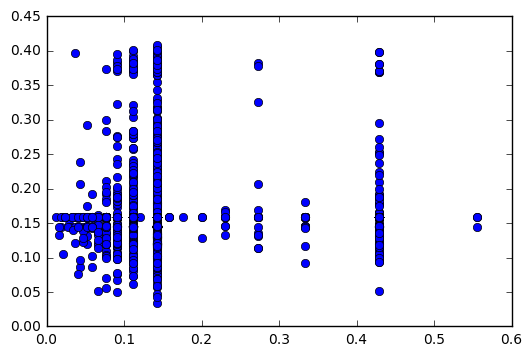

In [836]:
plt.plot(dfSu['F'],dfSu['E'],'o')
plt.show()

In [837]:
np.corrcoef(np.array(dfSu['F']),np.array(dfSu['E']))     

array([[ 1.        ,  0.00102968],
       [ 0.00102968,  1.        ]])

In [838]:
np.array(dfSh['D'])

array([ 0.14285714,  0.14285714,  0.11111111, ...,  0.14285714,
        0.14285714,  0.11111111])

In [767]:
dfSh

,A,B,C,D
0,-2080333824,155154,0.158868,0.142857
1,-2106785788,729088,0.115750,0.142857
2,-2106785788,1945528,0.144412,0.111111
3,-2102370298,156171489,0.158868,0.142857
4,-2145665013,28288615,0.144313,0.142857
5,-2145665013,92447052,0.144313,0.142857
6,-2101084148,111604897,0.144361,0.142857
7,-2101084148,128901626,0.144361,0.142857
8,-2139168754,780052,0.158868,0.428571
9,-2085674948,802651,0.158868,0.111111


In [768]:
result1=pd.merge(dfSh,dfSu,on=['A','B'])

In [769]:
val=result1.ix[1:800,:]

In [770]:
train=result1.ix[800:,:]

In [771]:
def loss(beta, df):
    pred = beta[0]*df['C']+beta[1]*df['E']+beta[2]
    return np.sum((pred-df['D'])**2), pred

In [772]:
from scipy import optimize as optm

In [773]:
result1.shape

(7538, 6)

In [774]:
resultParameters = optm.minimize(fun=loss,x0=[0,0,0],args=result1,tol=1e-4,options={'maxiter': 10000000})
print(resultParameters)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [ ]:
len(df)

In [ ]:
def grad(beta,df):
    kk=(beta[0]*df['C']+beta[1]*df['E']+beta[2]-df['D'])
    #return np.array([2*np.dot(kk,df['C']),2*np.dot(kk,df['D']),np.sum(2*kk)])
    return np.array([2*np.dot(kk,df['C']),0,np.sum(2*kk)])

In [ ]:
x1=np.array([1,2,3])
x2=np.array([4,5,6])

In [ ]:
np.dot(x1,x2)

In [ ]:
#train , val, test = ...

#loss(beta,df)  # loss, pred s_hat
#grad(beta,df)  # gradient   output[2*s_hat *s1,2*s_hat *s2,2*s_hat ]

maxIter = 50000
beta = np.array([1,0,1]).astype('float64')
lr = 1e-6

for iter in range(maxIter):
    beta -= [lr*x for x in grad(beta,train)]
    loss_train, _ = loss(beta, train)
    loss_val, _ = loss(beta, val)
    if iter%1000==0:
        print(iter,loss_train, loss_val)




In [ ]:
loss_test, pred = loss(beta,train)  # output the prediction error

beta

In [ ]:
plt.plot(pred, train['D'],'o')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(dfSu['E'],dfSu['F'],'o')
plt.show()

In [ ]:
dfSu['E']

In [ ]:
trunc_TEST = dat.ix[1000:1200,:]